In [6]:
import pandas as pd
import numpy as np
from pandas import Series, DataFrame
import os
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats
sns.set()
%matplotlib notebook

In [76]:
def KovalT(mean_log, sd_log, mean_nor, sd_nor, sizen, iteras):
    """
    This function computes and stores the linear regression results of
    the Koval plot. Parameters:
    Permeability: lognormal; mean and standard deviation
    Porosity: normal; mean and standard deviation
    sizen: number of points of the data sets
    iteras: the number of linear regression analysis to be performed.
    """
    
    KLR = pd.DataFrame(np.zeros((iteras, 7)),
                      columns=['Porosity Mean', 'Permeability Mean', 'Slope', 'Intercept',
                               'P value', 'R^2', 'Standard Error']) # initializing DataFrame of results
    
    plot_Koval = pd.DataFrame(np.zeros((sizen, iteras * 2)))
    
    for itera in np.arange(iteras):
        # Compute the mean and standard deviation of lognormal pdf in terms of
        # the normal distribution
        normal_std = np.sqrt(np.log(1 + (sd_log/mean_log)**2))
        normal_mean = np.log(mean_log) - normal_std**2 / 2
        
        # Create DataFrame and permeability and porosity columns
        x = pd.DataFrame(np.random.lognormal(normal_mean, normal_std, size=sizen),
                         columns=['permeability'])
        x['porosity'] = np.random.normal(mean_nor, sd_nor, size=sizen)
        
        # Obtain the total sum of both permeability and porosity
        sumk = x['permeability'].sum()
        sumphi = x['porosity'].sum()
        x['interst vel'] = x['permeability'] / x['porosity'] # Interstitial velocity
        
        # Sort the interstitial velocity in descending order
        x.sort_values(by=['interst vel'], ascending=False, inplace=True)
        
        k1 = np.cumsum(pd.DataFrame(x['permeability']))
        phi1 = np.cumsum(pd.DataFrame(x['porosity']))
        x['(1-F)/F'] = (sumk / k1) - 1
        x['(1-C)/C'] = (sumphi / phi1) - 1
        x.where(x > 0, 0, inplace=True) # if there are negative values in the DataFrame, replace them with 0
        x.where(x > 1e-8, 0, inplace=True) # replace values < 1e-8 with 0
        # x.drop(['interst vel'], axis=1, inplace=True)
                
        # Linear regression
        slope, intercept, r_value, p_value, std_err = stats.linregress(
        x['(1-C)/C'], x['(1-F)/F'])
        
        # Store results of linear regression
        KLR.iloc[itera, 0:2] = (x['porosity'].mean(), x['permeability'].mean())
        KLR.iloc[itera, 2:] = slope, intercept, p_value, r_value ** 2, std_err
        
        # Store Koval data sets for plotting
        plot_Koval.iloc[:, 2 * itera] = x['(1-C)/C'].values
        plot_Koval.iloc[:, 2 * itera + 1] = x['(1-F)/F'].values
        
    return KLR, plot_Koval

In [77]:
def KovalF(mean_log, sd_log, mean_nor, sd_nor, sizen, iteras, k_fr):
    """
    This function computes and stores the linear regression results of
    the Koval plot. Parameters:
    Permeability: lognormal; mean and standard deviation [md]
    Porosity: normal; mean and standard deviation
    sizen: number of points of the data sets
    iteras: the number of linear regression analyses to be performed
    k_fr: the permeability value for a fracture (in order of darcies)
    """
    
    import random
    
    KLR = pd.DataFrame(np.zeros((iteras, 7)),
                      columns=['Porosity Mean', 'Permeability Mean', 'Slope', 'Intercept',
                               'P value', 'R^2', 'Standard Error']) # initializing DataFrame of results
    
    plot_Koval = pd.DataFrame(np.zeros((sizen, iteras * 2)))
    
    # kphi = pd.DataFrame(np.zeros((sizen, iteras * 2)))
    
    for itera in np.arange(iteras):
        # Compute the mean and standard deviation of lognormal pdf in terms of
        # the normal distribution
        normal_std = np.sqrt(np.log(1 + (sd_log/mean_log)**2))
        normal_mean = np.log(mean_log) - normal_std **2 / 2
        
        # Create DataFrame and permeability and porosity columns
        perm1 = np.random.lognormal(normal_mean, normal_std, size=sizen) # first data set of permeability
        
        perm2 = np.random.random(*perm1.shape) * (k_fr - sd_log) + (k_fr + sd_log)
        # This creates a data set of fractured permeability values: k_fracture - std dev k < k < k_fracture + std dev k
        
        ten_per = int(np.floor(sizen * 0.1)) # ten percent = 0.1
        perm1[np.random.randint(0, sizen, size=ten_per)] = random.sample(list(perm2), ten_per)
        # The data set perm1 is updated by randomly modifying 10% of its values to high permeability values
        
        x = pd.DataFrame(perm1, columns=['permeability'])
        x['porosity'] = np.random.normal(mean_nor, sd_nor, size=sizen)
        
        # Obtain the total sum of both permeability and porosity
        sumk = x['permeability'].sum()
        sumphi = x['porosity'].sum()
        x['interst vel'] = x['permeability'] / x['porosity'] # Interstitial velocity
        
        # Sort the interstitial velocity in descending order
        x.sort_values(by=['interst vel'], ascending=False, inplace=True)
        
        k1 = np.cumsum(pd.DataFrame(x['permeability']))
        phi1 = np.cumsum(pd.DataFrame(x['porosity']))
        x['(1-F)/F'] = (sumk / k1) - 1
        x['(1-C)/C'] = (sumphi / phi1) - 1
        x.where(x > 0, 0, inplace=True) # if there are negative values in the DataFrame, replace them with 0
        x.where(x > 1e-8, 0, inplace=True) # replace values < 1e-8 with 0
        #x.drop(['interst vel'], axis=1, inplace=True)
        
        # Linear regression
        slope, intercept, r_value, p_value, std_err = stats.linregress(
        x['(1-C)/C'], x['(1-F)/F'])
        
        # Store linear regression results
        KLR.iloc[itera, 0:2] = (x['porosity'].mean(), x['permeability'].mean())
        # Store linear regression results
        KLR.iloc[itera, 2:] = slope, intercept, p_value, r_value ** 2, std_err
        
        # Store Koval data sets for plotting.
        # Even columns: (1-C)/C; Odd columns: (1-F)/F
        plot_Koval.iloc[:, 2 * itera] = x['(1-C)/C'].values
        plot_Koval.iloc[:, 2 * itera + 1] = x['(1-F)/F'].values
        
        # Store permeability values of porosity and permeability
        # kphi.iloc[:, 2 * itera] = x['porosity']
        # kphi.iloc[:, 2 * itera + 1] = x['permeability']
        
    return KLR, plot_Koval

In [95]:
np.random.seed(seed=12345)
reb1, plt_reb1 = KovalF(1000, 80, 0.25, 0.03, 10000, 1, 5000)
np.random.seed(seed=12345)
reb2, plt_reb2 = KovalT(95, 80, 0.25, 0.03, 10000, 1)

<IPython.core.display.Javascript object>


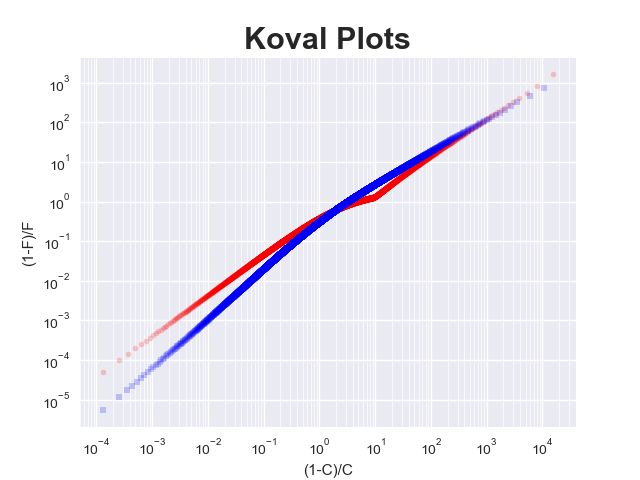

In [96]:
fig, ax = plt.subplots()
rows , columns = plt_reb1.shape

for i in np.arange(int(columns / 2)):
    plt.plot(plt_reb1.iloc[:, 2 * i], plt_reb1.iloc[:, 2 * i + 1], 'ro', markersize=4, alpha=0.2)
    plt.plot(plt_reb2.iloc[:, 2 * i], plt_reb2.iloc[:, 2 * i + 1], 'bs', markersize=4, alpha=0.2)
    
ax.set(xscale='log', yscale='log', xlabel='(1-C)/C', ylabel='(1-F)/F')

ax.set_title('Koval Plots', weight='bold', size=22)

ax.xaxis.grid(True, which='minor', linestyle='-', linewidth=0.5,)
ax.xaxis.grid(True, which='minor', linestyle='-', linewidth=0.5,);

In [86]:
rows

1000

In [73]:
reb2.describe()

,Porosity Mean,Permeability Mean,Slope,Intercept,P value,R^2,Standard Error
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.0,1000.000000,1000.000000
mean,0.250041,20.004209,0.425835,0.627132,0.0,0.995473,0.000797
std,0.000964,0.160523,0.036206,0.155579,0.0,0.004916,0.000295
min,0.246547,19.565697,0.280309,0.293656,0.0,0.942486,0.000228
25%,0.249413,19.894712,0.402861,0.513917,0.0,0.994286,0.000579
50%,0.250004,20.011265,0.428116,0.610352,0.0,0.996925,0.000744
75%,0.250698,20.110508,0.452028,0.725769,0.0,0.998341,0.000969
max,0.252803,20.465295,0.513529,1.352906,0.0,0.999796,0.002192


In [52]:
plt_lc.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,1084.702931,148.940480,1183.173296,115.741533,1080.797173,109.512754,983.342940,105.252821,1451.141109,127.400771,...,1030.315036,117.356950,943.495010,104.252918,971.609638,151.360888,1057.455146,107.291282,922.641653,123.602123
1,474.842231,66.976539,503.557988,49.991963,531.636576,54.422442,501.631654,61.033073,667.848616,74.004657,...,553.365735,63.874299,468.743070,55.068001,535.183786,91.147465,498.926779,61.329335,488.930083,65.578443
2,327.902841,49.264973,337.907518,37.675286,369.833200,39.317025,330.263942,42.106115,417.938918,50.552661,...,371.373276,48.476115,321.508063,40.505914,361.617057,65.276610,357.986632,46.507047,320.487745,43.125096
3,248.129783,39.017341,242.071914,30.232393,275.941614,30.848397,249.069539,33.173357,305.392782,38.692729,...,286.975366,40.137200,252.925917,32.931250,257.530194,48.846258,268.564383,36.264989,243.897499,33.862538
4,204.415387,33.153365,199.924200,26.419061,215.582772,26.021319,197.626795,27.441345,229.522234,30.250440,...,218.861083,32.452935,209.606711,27.987883,207.711123,40.326857,206.072870,29.328893,194.093947,27.694868


In [54]:
reb.describe()

,Porosity Mean,Permeability Mean,Slope,Intercept,P value,R^2,Standard Error
count,100.000000,100.000000,100.000000,100.000000,100.0,100.000000,100.000000
mean,0.250088,517.409930,0.069230,-0.071982,0.0,0.997831,0.000097
std,0.000941,11.564735,0.005638,0.023161,0.0,0.001531,0.000022
min,0.248117,490.366619,0.055010,-0.110138,0.0,0.991586,0.000069
25%,0.249511,510.173063,0.065774,-0.090321,0.0,0.997882,0.000084
50%,0.250078,516.795714,0.069945,-0.076878,0.0,0.998424,0.000091
75%,0.250658,526.537052,0.073212,-0.059431,0.0,0.998586,0.000101
max,0.252539,544.719924,0.080080,-0.014781,0.0,0.998919,0.000168
